In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima, ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors

### Stationary model

In [30]:
hd = pd.read_csv('datasets/hd.csv')
hd.head()

,id,dzien_rozliczenia,product1,product2,product3,product4
0,7,2023-11-04,90.0,67,0.0,1.0
1,6,2023-11-04,39.0,27,0.0,0.0
2,1,2023-11-04,131.0,74,0.0,0.0
3,9,2023-11-04,56.0,30,0.0,0.0
4,4,2023-11-04,115.0,56,0.0,0.0


In [33]:
point_ids = set(hd.id)

In [36]:
def simple_sales_predictor(sales_data, date):
    if len(sales_data) < 7:
        return "Insufficient data for prediction"
    else:
        sales_data = sales_data[sales_data.dzien_rozliczenia <= date]
        last_7_days_sales = sales_data[1:8].product1
        average_sales = sum(last_7_days_sales) / 7
        return average_sales, sales_data.iloc[0].product1

In [37]:
for point in point_ids:
    pred, true = simple_sales_predictor(hd[hd.id == point], '2023-10-04')
    print("point id: "+str(point), "pred: "+str(pred), "true: "+str(true))

point id: 1 pred: 100.14285714285714 true: 77.0
point id: 2 pred: 136.0 true: 125.0
point id: 3 pred: 72.85714285714286 true: 81.0
point id: 4 pred: 72.35714285714286 true: 64.0
point id: 37 pred: 70.57142857142857 true: 62.0
point id: 6 pred: 53.57142857142857 true: 90.5
point id: 7 pred: 73.92857142857143 true: 72.0
point id: 8 pred: 97.21428571428571 true: 93.0
point id: 9 pred: 58.92857142857143 true: 61.0
point id: 5 pred: 36.0 true: 58.0


In [38]:
def last_week_predictor(sales_data, date):
    if len(sales_data) < 7:
        return "Insufficient data for prediction"
    else:
        sales_data = sales_data[sales_data.dzien_rozliczenia <= date]
        last_week_sale = sales_data.iloc[6].product1
        return last_week_sale, sales_data.iloc[0].product1

In [39]:
for point in point_ids:
    pred, true = last_week_predictor(hd[hd.id == point], '2023-10-04')
    print("point id: "+str(point), "pred: "+str(pred), "true: "+str(true))

point id: 1 pred: 98.0 true: 77.0
point id: 2 pred: 142.0 true: 125.0
point id: 3 pred: 66.0 true: 81.0
point id: 4 pred: 74.0 true: 64.0
point id: 37 pred: 70.0 true: 62.0
point id: 6 pred: 92.0 true: 90.5
point id: 7 pred: 75.0 true: 72.0
point id: 8 pred: 107.0 true: 93.0
point id: 9 pred: 59.0 true: 61.0
point id: 5 pred: 68.0 true: 58.0


In [40]:
def last_weeks_avg_predictor(sales_data, date):
    if len(sales_data) < 7:
        return "Insufficient data for prediction"
    else:
        sales_data = sales_data[sales_data.dzien_rozliczenia <= date]
        sum = 0 
        for i in range(3):
            sum += sales_data.iloc[6+(i*6)].product1
        return sum / 3, sales_data.iloc[0].product1

In [41]:
for point in point_ids:
    pred, true = last_weeks_avg_predictor(hd[hd.id == point], '2023-10-04')
    print("point id: "+str(point), "pred: "+str(pred), "true: "+str(true))

point id: 1 pred: 94.33333333333333 true: 77.0
point id: 2 pred: 161.66666666666666 true: 125.0
point id: 3 pred: 67.33333333333333 true: 81.0
point id: 4 pred: 73.0 true: 64.0
point id: 37 pred: 69.66666666666667 true: 62.0
point id: 6 pred: 99.33333333333333 true: 90.5
point id: 7 pred: 81.66666666666667 true: 72.0
point id: 8 pred: 98.33333333333333 true: 93.0
point id: 9 pred: 55.333333333333336 true: 61.0
point id: 5 pred: 66.66666666666667 true: 58.0


In [42]:
data = hd[hd.id == 1][::-1]
data.reset_index(drop=True, inplace=True)
y_train = data[data.dzien_rozliczenia <= '2023-08-04'].product1
test_data = data[data.dzien_rozliczenia > '2023-08-04']
y_test = test_data.product1

In [43]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [44]:
auto = auto_arima(y_test, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=804.953, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=757.485, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=802.953, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=740.337, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=732.609, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=734.304, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=730.609, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=738.337, Time=0.00 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=732.305, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA

In [45]:
print(auto.order)

(3, 1, 0)


In [46]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    print("pred: "+str(fc), "true: "+str(new_ob))
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


pred: 81.95701053696195 true: 131.5
pred: 86.98808470426992 true: 67.0
pred: 121.53741204186217 true: 97.0
pred: 116.85533792331148 true: 98.0
pred: 95.57262448411424 true: 106.0
pred: 84.52138072513867 true: 80.0
pred: 103.37709558645966 true: 138.0
pred: 88.42437847372516 true: 111.0
pred: 103.5997428358451 true: 84.0
pred: 116.72548790151279 true: 105.0
pred: 113.82235608195978 true: 80.0
pred: 101.57246035046776 true: 126.0
pred: 85.22728981361175 true: 73.0
pred: 106.21365639884058 true: 96.0
pred: 96.43349567610358 true: 90.0
pred: 97.65661080374994 true: 113.0
pred: 82.5196590409766 true: 70.0
pred: 103.60854206152669 true: 140.0
pred: 84.24857573675584 true: 87.0
pred: 106.84970428678534 true: 85.0
pred: 105.82685897067098 true: 88.0
pred: 106.82720266260381 true: 98.0
pred: 84.46152794829449 true: 78.0
pred: 92.08132961059573 true: 145.0
pred: 78.7564340376499 true: 79.0
pred: 108.4475487859088 true: 88.0
pred: 107.86878570081761 true: 93.0
pred: 105.0590343366676 true: 98.0
p

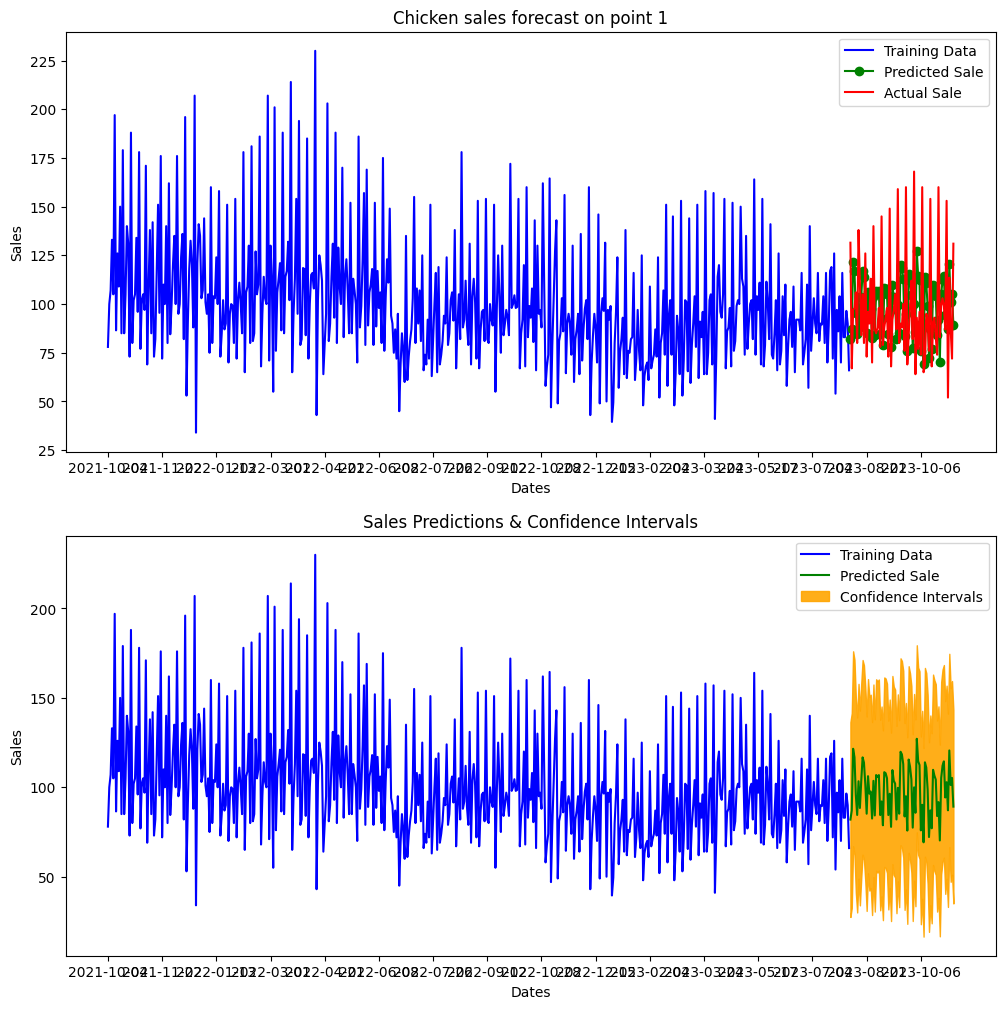

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Sale')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Sale')
axes[0].set_title('Chicken sales forecast on point 1')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Sales')

axes[0].set_xticks(np.arange(0, len(y_train)+len(test_data), 40).tolist(), data['dzien_rozliczenia'][0:len(y_train)+len(test_data):40].tolist())
axes[0].legend()

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Sale')

axes[1].set_title('Sales Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Sales')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, len(y_train)+len(test_data), 40).tolist(), data['dzien_rozliczenia'][0:len(y_train)+len(test_data):40].tolist())
axes[1].legend()

In [49]:
hd = hd[::-1]

In [51]:
knn_x = pd.DataFrame()
knn_y = pd.DataFrame()
point_ids = set(hd.id)
for point in point_ids:
    knn_point_x = pd.DataFrame()
    knn_point_x['id'] = hd[hd.id == point].id
    knn_point_x['dzien_rozliczenia'] = hd[hd.id == point].dzien_rozliczenia
    for i in range(1, 61):
        knn_point_x[f'-{i}'] = hd[hd.id == point].product1.shift(i)
    knn_point_x.dropna(inplace=True)

    knn_point_y = pd.DataFrame()
    pom = hd[(hd.id == point) & (hd.dzien_rozliczenia >= knn_point_x.iloc[0].dzien_rozliczenia)]
    knn_point_y['id'] = pom.id
    knn_point_y['dzien_rozliczenia'] = pom.dzien_rozliczenia
    knn_point_y['product1'] = pom.product1

    knn_x = pd.concat([knn_x, knn_point_x], ignore_index=True)
    knn_y = pd.concat([knn_y, knn_point_y], ignore_index=True)
knn_x.reset_index(drop=True, inplace=True)
knn_x

,id,dzien_rozliczenia,-1,-2,-3,-4,-5,-6,-7,-8,...,-51,-52,-53,-54,-55,-56,-57,-58,-59,-60
0,1,2021-12-14,91.0,53.0,196.0,82.0,136.0,124.0,100.0,95.0,...,150.0,109.0,126.0,86.5,197.0,105.0,133.0,107.0,100.0,78.0
1,1,2021-12-15,118.0,91.0,53.0,196.0,82.0,136.0,124.0,100.0,...,85.0,150.0,109.0,126.0,86.5,197.0,105.0,133.0,107.0,100.0
2,1,2021-12-16,132.5,118.0,91.0,53.0,196.0,82.0,136.0,124.0,...,179.0,85.0,150.0,109.0,126.0,86.5,197.0,105.0,133.0,107.0
3,1,2021-12-17,120.0,132.5,118.0,91.0,53.0,196.0,82.0,136.0,...,85.0,179.0,85.0,150.0,109.0,126.0,86.5,197.0,105.0,133.0
4,1,2021-12-18,88.0,120.0,132.5,118.0,91.0,53.0,196.0,82.0,...,105.0,85.0,179.0,85.0,150.0,109.0,126.0,86.5,197.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,37,2023-10-30,103.0,64.0,55.0,70.0,62.0,49.0,110.0,77.0,...,87.0,74.0,70.0,58.0,86.0,63.0,66.0,69.0,71.0,57.0
5175,37,2023-10-31,53.0,103.0,64.0,55.0,70.0,62.0,49.0,110.0,...,64.0,87.0,74.0,70.0,58.0,86.0,63.0,66.0,69.0,71.0
5176,37,2023-11-02,104.0,53.0,103.0,64.0,55.0,70.0,62.0,49.0,...,107.0,64.0,87.0,74.0,70.0,58.0,86.0,63.0,66.0,69.0
5177,37,2023-11-03,50.0,104.0,53.0,103.0,64.0,55.0,70.0,62.0,...,60.0,107.0,64.0,87.0,74.0,70.0,58.0,86.0,63.0,66.0


In [52]:
knn_y

,id,dzien_rozliczenia,product1
0,1,2021-12-14,118.0
1,1,2021-12-15,132.5
2,1,2021-12-16,120.0
3,1,2021-12-17,88.0
4,1,2021-12-18,207.0
...,...,...,...
5174,37,2023-10-30,53.0
5175,37,2023-10-31,104.0
5176,37,2023-11-02,50.0
5177,37,2023-11-03,53.0


In [53]:
x_train_full = knn_x[knn_x.dzien_rozliczenia < '2023-08-04']
x_test_full = knn_x[knn_x.dzien_rozliczenia >= '2023-08-04']
y_train = knn_y[knn_y.dzien_rozliczenia < '2023-08-04'].product1
y_test = knn_y[knn_y.dzien_rozliczenia >= '2023-08-04'].product1

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train_full.drop(columns=['dzien_rozliczenia', 'id']))
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test_full.drop(columns=['dzien_rozliczenia', 'id']))
x_test = pd.DataFrame(x_test_scaled)

In [55]:
rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)
    pred=model.predict(x_test)
    error = np.sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 23.63473942782592
RMSE value for k=  2 is: 20.669925255207527
RMSE value for k=  3 is: 19.987061302027353
RMSE value for k=  4 is: 19.820856096990305
RMSE value for k=  5 is: 19.636449618790177
RMSE value for k=  6 is: 20.249634071074336
RMSE value for k=  7 is: 20.516294645224626
RMSE value for k=  8 is: 20.467547088198227
RMSE value for k=  9 is: 20.35246252614144
RMSE value for k=  10 is: 20.295616855554947
RMSE value for k=  11 is: 20.178973712197703
RMSE value for k=  12 is: 20.294721484825754
RMSE value for k=  13 is: 20.353299217369344
RMSE value for k=  14 is: 20.35566787861595
RMSE value for k=  15 is: 20.358542696068277
RMSE value for k=  16 is: 20.328582615813307
RMSE value for k=  17 is: 20.38969504626211
RMSE value for k=  18 is: 20.50435722813541
RMSE value for k=  19 is: 20.549571459884113
RMSE value for k=  20 is: 20.724517148380553


Best K: 4


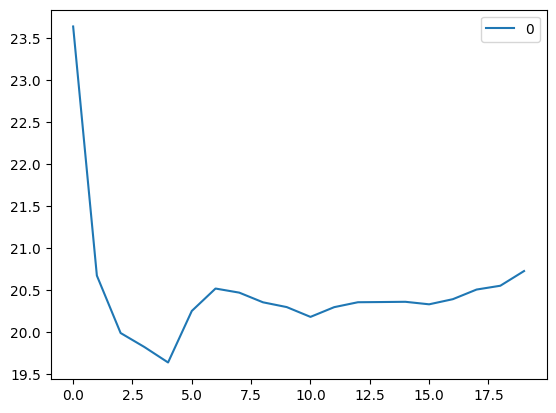

In [56]:
curve = pd.DataFrame(rmse_val)
curve.plot()
best_K = min(range(len(rmse_val)), key=rmse_val.__getitem__)
print("Best K: "+str(best_K))

In [57]:
model = neighbors.KNeighborsRegressor(n_neighbors = best_K)
model.fit(x_train, y_train)
pred=model.predict(x_test)
test_full = pd.concat([x_test_full, y_test], axis=1)
test_full['pred'] = pred
test_full

,id,dzien_rozliczenia,-1,-2,-3,-4,-5,-6,-7,-8,...,-53,-54,-55,-56,-57,-58,-59,-60,product1,pred
487,1,2023-08-04,90.0,96.5,83.0,83.0,116.0,70.0,104.0,86.0,...,66.0,102.0,85.0,72.0,74.0,141.0,82.0,101.0,66.0,74.750
488,1,2023-08-05,66.0,90.0,96.5,83.0,83.0,116.0,70.0,104.0,...,126.0,66.0,102.0,85.0,72.0,74.0,141.0,82.0,131.5,112.500
489,1,2023-08-07,131.5,66.0,90.0,96.5,83.0,83.0,116.0,70.0,...,69.0,126.0,66.0,102.0,85.0,72.0,74.0,141.0,67.0,52.500
490,1,2023-08-08,67.0,131.5,66.0,90.0,96.5,83.0,83.0,116.0,...,76.0,69.0,126.0,66.0,102.0,85.0,72.0,74.0,97.0,87.750
491,1,2023-08-09,97.0,67.0,131.5,66.0,90.0,96.5,83.0,83.0,...,104.0,76.0,69.0,126.0,66.0,102.0,85.0,72.0,98.0,85.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,37,2023-10-30,103.0,64.0,55.0,70.0,62.0,49.0,110.0,77.0,...,70.0,58.0,86.0,63.0,66.0,69.0,71.0,57.0,53.0,53.500
5175,37,2023-10-31,53.0,103.0,64.0,55.0,70.0,62.0,49.0,110.0,...,74.0,70.0,58.0,86.0,63.0,66.0,69.0,71.0,104.0,49.875
5176,37,2023-11-02,104.0,53.0,103.0,64.0,55.0,70.0,62.0,49.0,...,87.0,74.0,70.0,58.0,86.0,63.0,66.0,69.0,50.0,68.250
5177,37,2023-11-03,50.0,104.0,53.0,103.0,64.0,55.0,70.0,62.0,...,64.0,87.0,74.0,70.0,58.0,86.0,63.0,66.0,53.0,58.250


RMSE value for k = 4 on test set is: 19.820856096990305


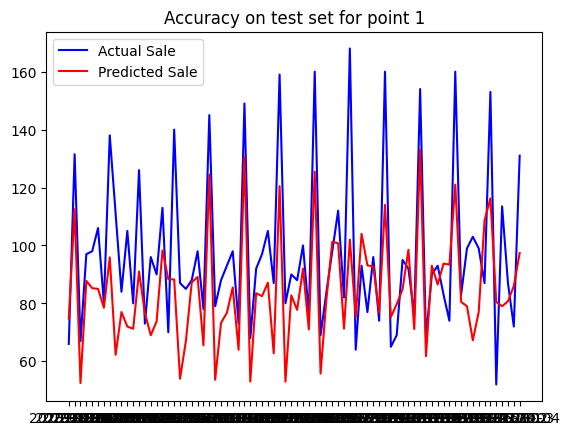

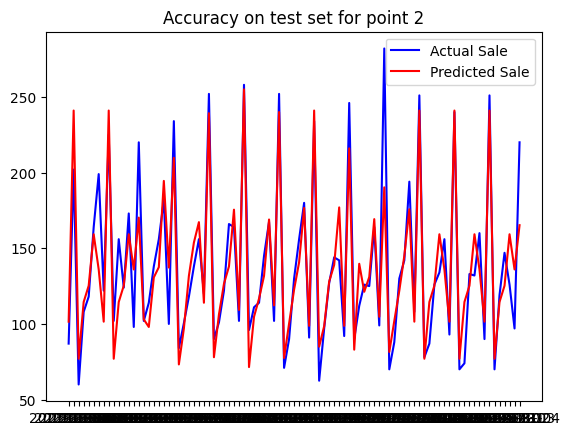

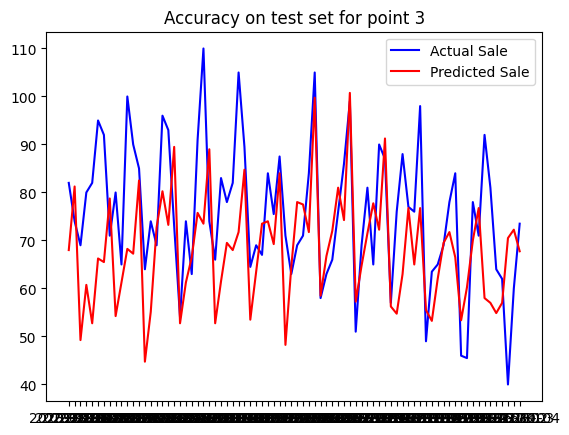

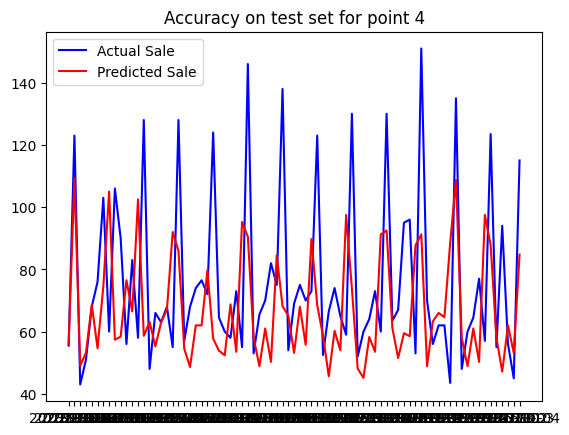

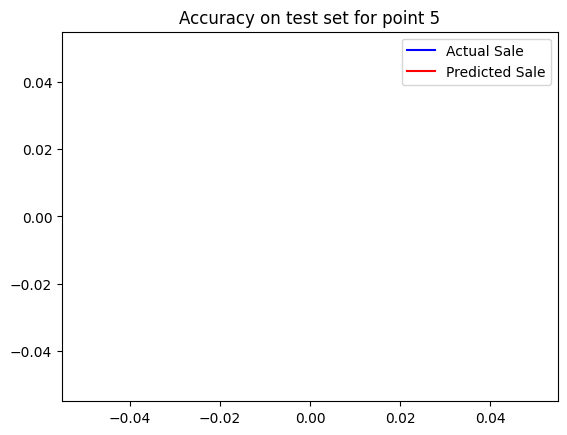

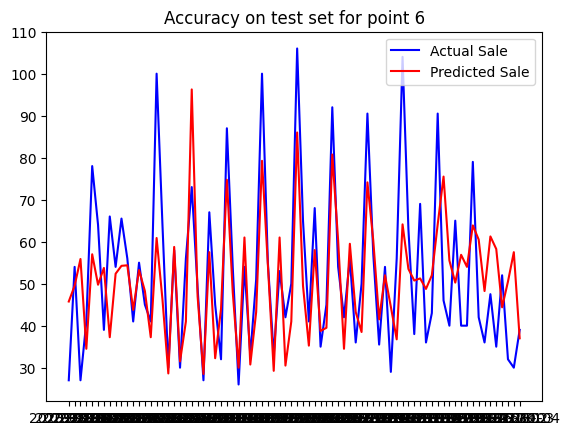

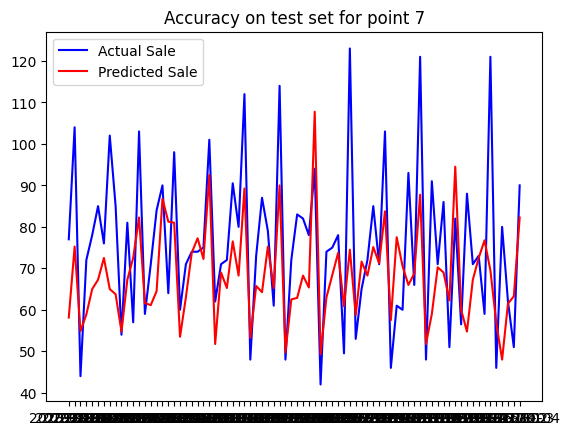

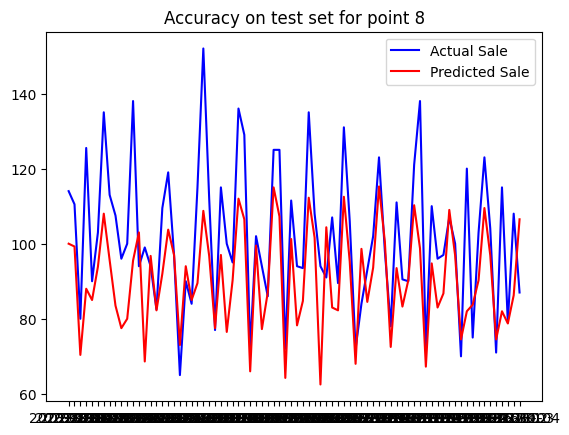

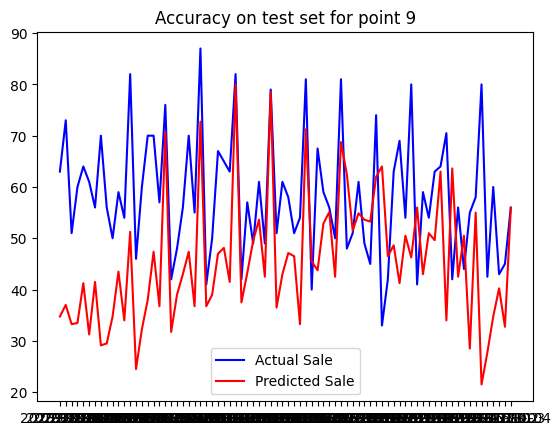

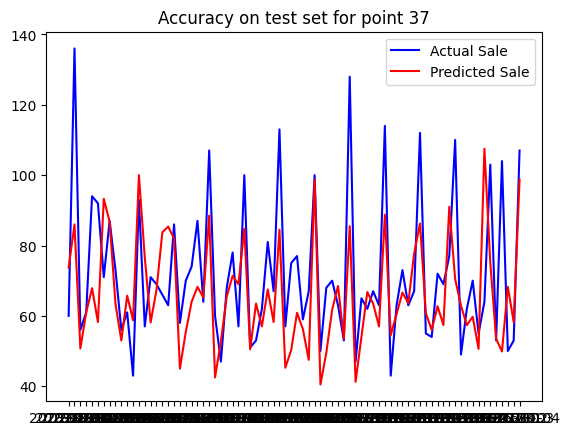

In [58]:
error = np.sqrt(mean_squared_error(y_test,pred))
print('RMSE value for k =' , best_K , 'on test set is:', error)
for point in point_ids:
    data = test_full[test_full.id == point]
    plt.title('Accuracy on test set for point ' + str(point))
    plt.plot(data.dzien_rozliczenia, data.product1, color='blue', label='Actual Sale')
    plt.plot(data.dzien_rozliczenia, data.pred, color='red', label='Predicted Sale')
    plt.legend()
    plt.show()